**Objective:**

The objective of this project is to develop and evaluate baseline classical machine learning models for the task of multi-class speech emotion recognition using hand-crafted audio features. The problem is formulated as a supervised classification task in which short speech utterances are categorized into one of eight emotional classes—Neutral, Calm, Happy, Sad, Angry, Fearful, Disgust, and Surprised—based on their acoustic characteristics.

To enable effective learning with traditional machine learning algorithms, raw speech signals from the RAVDESS dataset are transformed into fixed-length numerical feature vectors using Mel-Frequency Cepstral Coefficients (MFCCs). These features are widely used in speech processing due to their ability to represent perceptually meaningful information related to human vocal expression. Preprocessing steps such as signal standardization, feature aggregation, and feature scaling are applied to ensure data consistency and compatibility with classical classifiers.

Using the engineered MFCC features, several widely adopted non–deep-learning classifiers, including Logistic Regression, Support Vector Machines, Decision Trees, Random Forests, k-Nearest Neighbors, Naive Bayes, and Gradient Boosted Trees (XGBoost), are trained and evaluated. Model performance is assessed using standard metrics such as accuracy, precision, recall, F1-score (macro-averaged), and confusion matrices.

The results of this study establish a baseline performance benchmark that will be used for comparison with more advanced deep learning approaches in subsequent phases of the project.

**Dataset Description**

**Dataset Name & Source:**

RAVDESS (Ryerson Audio-Visual Database of Emotional Speech and Song) is a public academic dataset available via Zenodo/Kaggle.

**Nature of Data:**

The dataset contains audio speech recordings in WAV format representing human emotions. Audio is recorded at 48 kHz, mono channel, with an average duration of about 3 seconds per sample. For machine learning, audio signals are converted into numerical features (e.g., MFCCs), resulting in tabular data.

**Size & Features:**

The dataset includes 1,440 speech samples recorded by 24 professional actors (12 male, 12 female). After feature extraction, each sample is represented by a set of numerical features (exact number depends on the feature-engineering method used).

**Target Variable:**

The target variable is Emotion, consisting of 8 classes:
Neutral, Calm, Happy, Sad, Angry, Fearful, Disgust, and Surprised.

**Metadata & Quality:**

File names encode emotion label, intensity, and actor information. Recordings are collected in controlled studio conditions with no missing values in raw audio. The dataset is high quality but contains acted emotions and slight class imbalance. Preprocessing such as normalization, feature extraction, and feature scaling is required.

**Feature Engineering / Preprocessing**

Since the attributes within the dataset are audio (sequential time series) signals, the following tasks I carried out for preprocessing/feature creation:

**Audio Loading & Standardization:**

Every audio file of speech was loaded with a fixed target sampling rate. The audio samples were either zero-padded or truncated to a fixed length. This is because all samples should have the same uniform length.

**Feature Extraction:**

Mel-Frequency Cepstral Coefficients (MFCCs) were obtained for each audio signal, as they are adequate for capturing the properties of human voices with respect to expressing emotions. The mean of MFCC values over time was calculated to obtain fixed-size vectors from the variable-size MFCCs.

**Label Extraction:**

The emotion labels used were derived from the RAVDESS naming convention and corresponding to the following emotion categories: neutral, calm, happy, sad, angry, fearful, disgust, surprised. Feature Scaling: Since MFCC features are numeric values, and classical machine learning models are sensitive to scaling, a standardization preprocess (z-normalization) has been performed on the MFCC features using StandardScaler, which leads to zero-mean unit-variance features. Missing values & data quality: The resulting feature vectors were free from missing values. Additionally, because of the controlled recording environment, the effect of noise on the signals was minimal, eliminating the need to clean them. Final dataset representation: The preprocessing step results in a fixed-size, scaled numeric feature vector for each audio clip that is compatible with ML for use in classical machine learning classification models.

**Class Distribution**


In [ ]:
import pandas as pd

# Create DataFrame
df = pd.DataFrame({
    "Emotion_Label": labels
})

# Map numeric labels to emotion names (RAVDESS)
emotion_map = {
    1: "Neutral",
    2: "Calm",
    3: "Happy",
    4: "Sad",
    5: "Angry",
    6: "Fearful",
    7: "Disgust",
    8: "Surprised"
}

df["Emotion"] = df["Emotion_Label"].map(emotion_map)

# Count samples per class
class_distribution = df["Emotion"].value_counts().sort_index()

print("Class Distribution:\n")
print(class_distribution)


Class Distribution:

Emotion
Angry        384
Calm         384
Disgust      384
Fearful      384
Happy        384
Neutral      192
Sad          384
Surprised    384
Name: count, dtype: int64


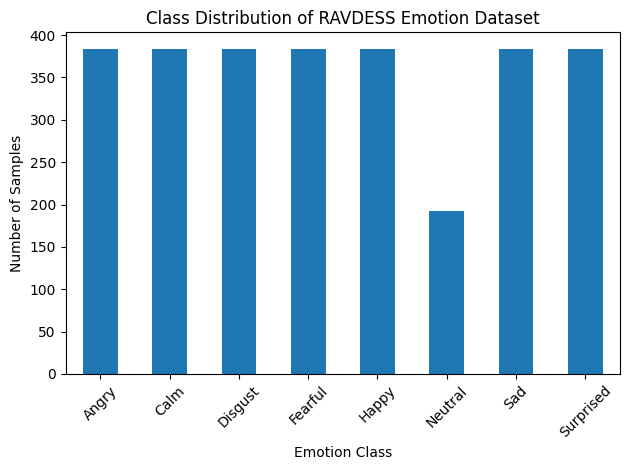

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
class_distribution.plot(kind='bar')
plt.xlabel("Emotion Class")
plt.ylabel("Number of Samples")
plt.title("Class Distribution of RAVDESS Emotion Dataset")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Preprocessing Data And Splitting Into Train And Test**

In [ ]:
TARGET_SR = 16000
FIXED_DURATION = 3.0
FEATURE_TYPE = "mel"
N_MELS = 128
N_MFCC = 40

In [ ]:
!pip install -q librosa soundfile kaggle tqdm

In [ ]:
import os
import shutil
import zipfile
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
import librosa
import soundfile as sf

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio --unzip -p /content/ravdess
!ls '/content/ravdess'

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
License(s): CC-BY-NC-SA-4.0
 95% 409M/429M [00:02<00:00, 133MB/s] 
100% 429M/429M [00:02<00:00, 152MB/s]
Actor_01  Actor_06  Actor_11  Actor_16	Actor_21
Actor_02  Actor_07  Actor_12  Actor_17	Actor_22
Actor_03  Actor_08  Actor_13  Actor_18	Actor_23
Actor_04  Actor_09  Actor_14  Actor_19	Actor_24
Actor_05  Actor_10  Actor_15  Actor_20	audio_speech_actors_01-24


In [ ]:
from pathlib import Path
AUDIO_ROOT = Path("/content/ravdess")
speech_wavs = sorted([p for p in AUDIO_ROOT.rglob('*.wav') if p.name.startswith('03-01-')])
print(f"Total speech audio-only files found: {len(speech_wavs)}")
print("First 5 files:")
for f in speech_wavs[:5]:
    print(f)

Total speech audio-only files found: 2880
First 5 files:
/content/ravdess/Actor_01/03-01-01-01-01-01-01.wav
/content/ravdess/Actor_01/03-01-01-01-01-02-01.wav
/content/ravdess/Actor_01/03-01-01-01-02-01-01.wav
/content/ravdess/Actor_01/03-01-01-01-02-02-01.wav
/content/ravdess/Actor_01/03-01-02-01-01-01-01.wav


In [ ]:
import librosa
import numpy as np
from sklearn.preprocessing import StandardScaler
features = []
labels = []
max_len = int(TARGET_SR * FIXED_DURATION)
print("Extracting MFCC features...")
for wav_path in tqdm(speech_wavs):
    y, sr = librosa.load(wav_path, sr=TARGET_SR)
    if len(y) < max_len:
        y = np.pad(y, (0, max_len - len(y)))
    else:
        y = y[:max_len]
    mfccs = librosa.feature.mfcc(y=y, sr=TARGET_SR, n_mfcc=N_MFCC)
    mfccs_mean = np.mean(mfccs.T, axis=0)
    features.append(mfccs_mean)
    emotion_code = int(wav_path.name.split('-')[2])
    labels.append(emotion_code)

features = np.array(features)
labels = np.array(labels)
print("Features shape:", features.shape)
print("Labels shape:", labels.shape)

Extracting MFCC features...


100%|██████████| 2880/2880 [00:58<00:00, 49.27it/s]

Features shape: (2880, 40)
Labels shape: (2880,)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    features,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (2304, 40)
Test shape: (576, 40)


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)   # fit ONLY on training data
X_test = scaler.transform(X_test)         # apply to test data
print("Features scaled correctly (no data leakage).")

Features scaled correctly (no data leakage).


**Training on Different Models**

**Hyperparameter Strategy**

In this baseline study, default or commonly used hyperparameters were selected for each model to establish a fair and simple baseline. Hyperparameter tuning using grid search or cross-validation is planned for future work.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np


In [ ]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)

    print(f"\n===== {model_name} =====")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))


LogisticRegression

In [ ]:
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

evaluate_model(lr, X_test, y_test, "Logistic Regression")


===== Logistic Regression =====
Accuracy: 0.4982638888888889

Classification Report:
              precision    recall  f1-score   support

           1       0.44      0.29      0.35        38
           2       0.56      0.62      0.59        76
           3       0.44      0.38      0.41        77
           4       0.53      0.51      0.52        77
           5       0.55      0.65      0.60        77
           6       0.52      0.44      0.48        77
           7       0.45      0.43      0.44        77
           8       0.44      0.57      0.50        77

    accuracy                           0.50       576
   macro avg       0.49      0.49      0.48       576
weighted avg       0.50      0.50      0.49       576


Confusion Matrix:
[[11  8  2  9  0  0  4  4]
 [ 6 47  0  9  0  0 10  4]
 [ 0  4 29  2 15 10  2 15]
 [ 2 15  8 39  2  1  1  9]
 [ 0  2  3  2 50  5  8  7]
 [ 3  0 11  5  6 34  8 10]
 [ 2  6  7  4 13  6 33  6]
 [ 1  2  6  3  5  9  7 44]]


Support Vector Machine

In [ ]:
svm = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm.fit(X_train, y_train)

evaluate_model(svm, X_test, y_test, "Support Vector Machine")



===== Support Vector Machine =====
Accuracy: 0.7621527777777778

Classification Report:
              precision    recall  f1-score   support

           1       0.80      0.63      0.71        38
           2       0.79      0.88      0.83        76
           3       0.77      0.62      0.69        77
           4       0.77      0.82      0.79        77
           5       0.87      0.77      0.81        77
           6       0.77      0.74      0.75        77
           7       0.70      0.75      0.72        77
           8       0.68      0.82      0.75        77

    accuracy                           0.76       576
   macro avg       0.77      0.75      0.76       576
weighted avg       0.77      0.76      0.76       576


Confusion Matrix:
[[24  7  1  4  0  0  1  1]
 [ 4 67  0  2  0  0  3  0]
 [ 0  1 48  2  4  8  3 11]
 [ 1  5  3 63  0  0  1  4]
 [ 0  1  2  2 59  4  5  4]
 [ 0  0  3  5  1 57  9  2]
 [ 0  3  2  2  0  5 58  7]
 [ 1  1  3  2  4  0  3 63]]


Decision Tree

In [ ]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

evaluate_model(dt, X_test, y_test, "Decision Tree")


===== Decision Tree =====
Accuracy: 0.8854166666666666

Classification Report:
              precision    recall  f1-score   support

           1       0.86      1.00      0.93        38
           2       0.89      0.87      0.88        76
           3       0.89      0.87      0.88        77
           4       0.89      0.84      0.87        77
           5       0.90      0.90      0.90        77
           6       0.88      0.95      0.91        77
           7       0.90      0.74      0.81        77
           8       0.86      0.97      0.91        77

    accuracy                           0.89       576
   macro avg       0.89      0.89      0.89       576
weighted avg       0.89      0.89      0.88       576


Confusion Matrix:
[[38  0  0  0  0  0  0  0]
 [ 2 66  2  4  0  0  0  2]
 [ 0  0 67  0  4  4  2  0]
 [ 0  4  2 65  0  2  2  2]
 [ 0  0  2  0 69  2  2  2]
 [ 0  0  0  2  0 73  0  2]
 [ 4  4  2  2  2  2 57  4]
 [ 0  0  0  0  2  0  0 75]]


In [ ]:
Random Forest

In [ ]:
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

evaluate_model(rf, X_test, y_test, "Random Forest")


===== Random Forest =====
Accuracy: 0.9270833333333334

Classification Report:
              precision    recall  f1-score   support

           1       0.95      0.95      0.95        38
           2       0.97      0.97      0.97        76
           3       0.90      0.92      0.91        77
           4       0.95      0.90      0.92        77
           5       0.97      0.87      0.92        77
           6       0.84      0.97      0.90        77
           7       0.94      0.87      0.91        77
           8       0.93      0.97      0.95        77

    accuracy                           0.93       576
   macro avg       0.93      0.93      0.93       576
weighted avg       0.93      0.93      0.93       576


Confusion Matrix:
[[36  0  0  0  0  0  0  2]
 [ 2 74  0  0  0  0  0  0]
 [ 0  0 71  0  0  4  2  0]
 [ 0  2  4 69  0  2  0  0]
 [ 0  0  2  0 67  4  2  2]
 [ 0  0  0  2  0 75  0  0]
 [ 0  0  2  2  0  4 67  2]
 [ 0  0  0  0  2  0  0 75]]


k-Nearest Neighbors

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

evaluate_model(knn, X_test, y_test, "k-Nearest Neighbors")


===== k-Nearest Neighbors =====
Accuracy: 0.7291666666666666

Classification Report:
              precision    recall  f1-score   support

           1       0.47      0.76      0.58        38
           2       0.86      0.83      0.85        76
           3       0.76      0.65      0.70        77
           4       0.71      0.58      0.64        77
           5       0.83      0.71      0.77        77
           6       0.64      0.71      0.67        77
           7       0.82      0.73      0.77        77
           8       0.73      0.87      0.79        77

    accuracy                           0.73       576
   macro avg       0.73      0.73      0.72       576
weighted avg       0.75      0.73      0.73       576


Confusion Matrix:
[[29  4  0  1  1  1  0  2]
 [11 63  0  1  0  0  0  1]
 [ 5  0 50  2  4  8  1  7]
 [ 8  3  3 45  1 13  4  0]
 [ 0  2  4  2 55  4  3  7]
 [ 2  0  6  9  2 55  2  1]
 [ 6  0  0  2  3  3 56  7]
 [ 1  1  3  1  0  2  2 67]]


Naive Bayes

In [ ]:
nb = GaussianNB()
nb.fit(X_train, y_train)

evaluate_model(nb, X_test, y_test, "Naive Bayes")


===== Naive Bayes =====
Accuracy: 0.3368055555555556

Classification Report:
              precision    recall  f1-score   support

           1       0.14      0.42      0.21        38
           2       0.45      0.46      0.46        76
           3       0.28      0.17      0.21        77
           4       0.29      0.06      0.11        77
           5       0.42      0.34      0.37        77
           6       0.38      0.34      0.36        77
           7       0.28      0.29      0.28        77
           8       0.46      0.66      0.54        77

    accuracy                           0.34       576
   macro avg       0.34      0.34      0.32       576
weighted avg       0.35      0.34      0.32       576


Confusion Matrix:
[[16  8  1  0  0  0  4  9]
 [23 35  1  2  0  0 13  2]
 [11  1 13  2 16 10 11 13]
 [23 15  8  5  1 12  8  5]
 [ 9  1  4  3 26 13  8 13]
 [14  5  9  5  4 26  6  8]
 [15 12  7  0  6  4 22 11]
 [ 5  0  3  0  9  3  6 51]]


XGBClassifier

In [ ]:
!pip install -q xgboost
from xgboost import XGBClassifier

# fix labels to 0-7
y_train_xgb = y_train - 1
y_test_xgb = y_test - 1

xgb = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softmax',
    num_class=8,
    random_state=42
)

xgb.fit(X_train, y_train_xgb)

y_pred = xgb.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Accuracy:", accuracy_score(y_test_xgb, y_pred))
print("\nClassification Report:\n", classification_report(y_test_xgb, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_xgb, y_pred))


Accuracy: 0.9409722222222222

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97        38
           1       1.00      0.95      0.97        76
           2       0.90      0.92      0.91        77
           3       0.93      0.97      0.95        77
           4       0.95      0.95      0.95        77
           5       0.92      0.92      0.92        77
           6       0.94      0.87      0.91        77
           7       0.95      0.97      0.96        77

    accuracy                           0.94       576
   macro avg       0.94      0.94      0.94       576
weighted avg       0.94      0.94      0.94       576


Confusion Matrix:
 [[38  0  0  0  0  0  0  0]
 [ 2 72  0  2  0  0  0  0]
 [ 0  0 71  0  0  4  2  0]
 [ 0  0  2 75  0  0  0  0]
 [ 0  0  0  0 73  2  2  0]
 [ 0  0  4  2  0 71  0  0]
 [ 0  0  2  2  2  0 67  4]
 [ 0  0  0  0  2  0  0 75]]


Results and Comparison Table

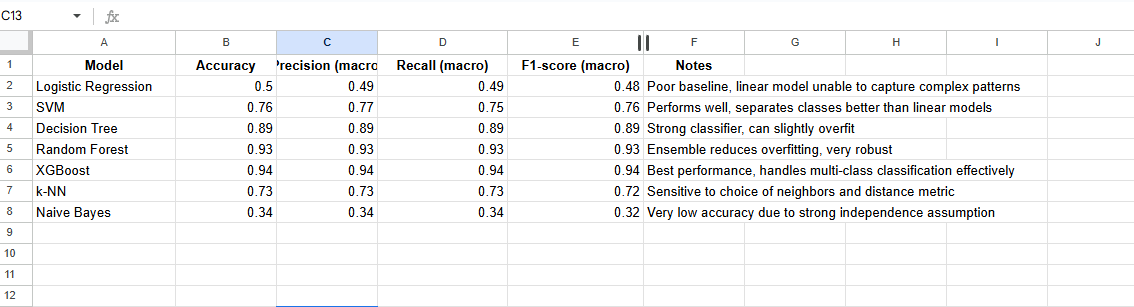

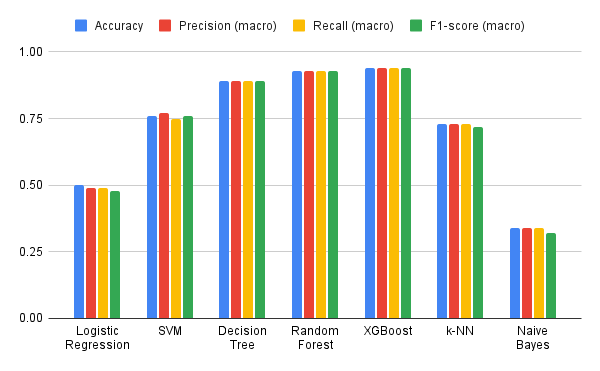

**Key Observations**

1- Ensemble models (**Random Forest, XGBoost**) achieved the highest accuracy
(**93–94%**) and consistently outperformed single classifiers.

2- Linear models (Logistic Regression, Naive Bayes) performed poorly, highlighting the non-linear complexity of MFCC features for emotion classification.

3- SVM and k-NN gave moderate performance (73–76%), showing some ability to separate classes, but not as strong as ensembles.

4- Confusion matrices indicate that misclassifications mostly occur between perceptually similar emotions (e.g., calm vs neutral, sad vs angry). XGBoost and Random Forest reduced these errors effectively.